# MHE Layers Paper Example
* MHE as CvxpyLayer, KF in pytorch
* System with constraints (threshold sensors)
* Learning uncertain parameter in system model

In [1]:
import math
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt

# import external functions
from functions.functions import *

In [2]:
# text style for plotting
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
    
# colors
color = ['y','m','c']

In [3]:
# define random seed
np.random.seed(1)

## system definition
nsim = 400

system = generate_cooling_system()

## generate estimator initialization
# wrong initialization
thermal_coupling_0 = 10.0

# MHE horizon
T = 10

# tensors to construct system matrix
Ac_local_tch = torch.tensor(system['Ac_local'])
Ac_coupling_tch = torch.tensor(system['Ac_coupling'])

mhe_layer, _, Ad_kf_tch, _, Ad_mhe_tch = initialize_estimators(system, T, thermal_coupling_0, Ac_local_tch, Ac_coupling_tch)

# generate initial state for validation
nx = system['nx']

while True:
    x0 = np.random.multivariate_normal(mean=system['x0_mean'],
                                       cov=system['P0']).reshape(nx,1)
    if (system['H_x0'] @ x0 <= system['h_x0']).all():
        break

nu = system['nu']

In [4]:
# simulation
inputs = generate_inputs(nsim,nu)
states, measurements, inputs = simulate(system,x0,inputs,nsim)

estimates_kalman, _ = generate_estimates_kalman_pytorch(nsim, system, inputs, measurements, Ad_kf_tch)

estimates_mhe, outputs_mhe, _ = generate_estimates_mhe(nsim, system, mhe_layer, inputs, measurements, Ad_mhe_tch, T)

Figure(864x216)


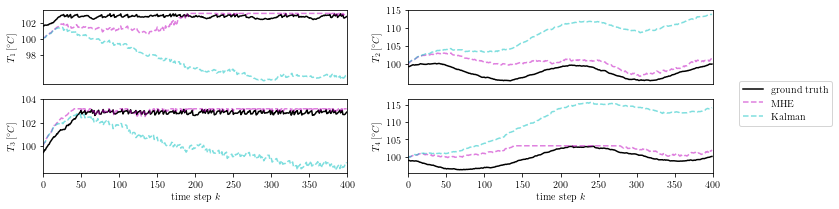

In [5]:
## plot simulation and estimation results

x_est_kf = torch.cat(estimates_kalman, 0).detach().numpy().reshape(-1,nx).transpose()
x_est_mhe = torch.cat(estimates_mhe, 0).detach().numpy().reshape(-1,nx).transpose()

# plot states
f, axs = plt.subplots(2,2, figsize=(12,3))
axs[0,0].plot(range(nsim), np.squeeze(states)[:,0], color='k')
axs[0,0].plot(range(nsim), x_est_mhe[0,:], color=color[1], alpha=0.5, linestyle='--')
axs[0,0].plot(range(nsim), x_est_kf[0,1:], color=color[2], alpha=0.5, linestyle='--')
axs[0,0].set_ylabel(r'$T_1 \left[^\circ C\right]$')
axs[0,0].xaxis.set_visible(False)
axs[0,0].set_yticks(np.arange(98,103,2))
axs[0,0].set_xlim([0,400])

axs[0,1].plot(range(nsim), np.squeeze(states)[:,1], color='k')
axs[0,1].plot(range(nsim), x_est_mhe[1,:], color=color[1], alpha=0.5, linestyle='--')
axs[0,1].plot(range(nsim), x_est_kf[1,1:], color=color[2], alpha=0.5, linestyle='--')
axs[0,1].set_ylabel(r'$T_2 \left[^\circ C\right]$')
axs[0,1].xaxis.set_visible(False)
axs[0,1].set_yticks(np.arange(100,116,5))
axs[0,1].set_xlim([0,400])

axs[1,0].plot(range(nsim), np.squeeze(states)[:,2], color='k')
axs[1,0].plot(range(nsim), x_est_mhe[2,:], color=color[1], alpha=0.5, linestyle='--')
axs[1,0].plot(range(nsim), x_est_kf[2,1:], color=color[2], alpha=0.5, linestyle='--')
axs[1,0].set_ylabel(r'$T_3 \left[^\circ C\right]$')
axs[1,0].set_xlabel('time step $k$')
axs[1,0].set_yticks(np.arange(100,105,2))
axs[1,0].set_xlim([0,400])

axs[1,1].plot(range(nsim), np.squeeze(states)[:,3], color='k', label="ground truth")
axs[1,1].plot(range(nsim), x_est_mhe[3,:], color=color[1], alpha=0.5, linestyle='--', label="MHE")
axs[1,1].plot(range(nsim), x_est_kf[3,1:], color=color[2], alpha=0.5, linestyle='--', label="Kalman")
axs[1,1].set_ylabel(r'$T_4 \left[^\circ C\right]$')
axs[1,1].set_xlabel('time step $k$')
axs[1,1].legend(loc='lower center', bbox_to_anchor=(1.24, 0.57), ncol=1)
axs[1,1].set_yticks(np.arange(100,116,5))
axs[1,1].set_xlim([0,400])
print(f)

In [6]:
states_mat = np.concatenate(states).reshape(-1,nx).transpose()
estimates_kalman_mat = torch.cat(estimates_kalman[1:], 0).detach().numpy().reshape(-1,nx).transpose()
estimates_mhe_mat = torch.cat(estimates_mhe, 0).detach().numpy().reshape(-1,nx).transpose()

print("Loss KF: ", gt_loss(states_mat, estimates_kalman_mat))
print("Loss MHE:", gt_loss(states_mat, estimates_mhe_mat))

Loss KF:  277.4429315875418
Loss MHE: 15.912580375372606


## Comparison of learning parameter in MHE and KF

In [7]:
torch.random.manual_seed(0)

# get validation data
val_inputs = generate_inputs(nsim,nu)
val_states, val_measurements, val_inputs = simulate(system,x0,val_inputs,nsim)

# training
epochs = 10
n_sim_epoch = 5
n_runs = 1 #20

# initial learning rates
alpha_0_kf = 6
alpha_0_mhe = 6

runs_tc_values_kf = []
runs_tc_values_mhe = []
runs_losses_kf = []
runs_losses_mhe = []
runs_val_losses_kf = []
runs_val_losses_mhe = []

inputs = {}
inputs['alpha_0_kf'] = alpha_0_kf
inputs['alpha_0_mhe'] = alpha_0_mhe
inputs['epochs'] = epochs
inputs['n_sim_epoch'] = n_sim_epoch
inputs['T'] = T
inputs['thermal_coupling_0'] = thermal_coupling_0
inputs['Ac_local_tch'] = Ac_local_tch
inputs['Ac_coupling_tch'] = Ac_coupling_tch
inputs['val_inputs'] = val_inputs
inputs['val_measurements'] = val_measurements
inputs['val_states'] = val_states
inputs['nsim'] = nsim

for i in range(n_runs):
    print('Learning run: ', i)
    outputs = learn_kf_mhe(system, inputs)
    runs_tc_values_kf.append(outputs['tc_values_kf'])
    runs_tc_values_mhe.append(outputs['tc_values_mhe'])
    runs_losses_kf.append(outputs['losses_kf'])
    runs_losses_mhe.append(outputs['losses_mhe'])
    runs_val_losses_kf.append(outputs['val_losses_kf'])
    runs_val_losses_mhe.append(outputs['val_losses_mhe'])

x_est_kf_val_init = outputs['x_est_kf_val_init']
x_est_mhe_val_init = outputs['x_est_mhe_val_init']
x_est_kf_val_final = outputs['x_est_kf_val_final']
x_est_mhe_val_final = outputs['x_est_mhe_val_final']

Learning run:  0
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


(0.0, 400.0)

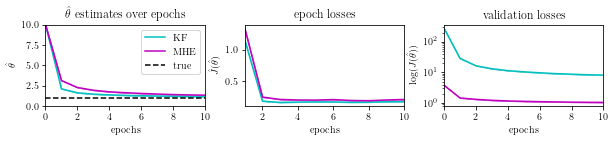

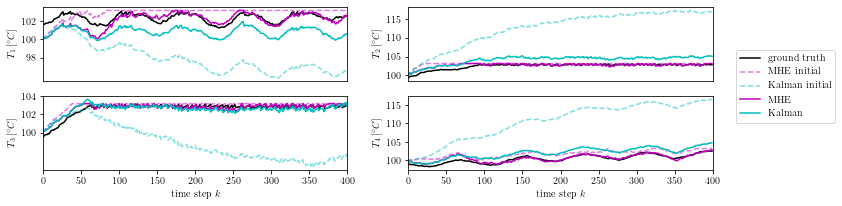

In [8]:
# statistics
med_tc_values_mhe = np.median(runs_tc_values_mhe, axis=0)
min_tc_values_mhe = np.min(runs_tc_values_mhe, axis=0)
max_tc_values_mhe = np.max(runs_tc_values_mhe, axis=0)

med_tc_values_kf = np.median(runs_tc_values_kf, axis=0)
min_tc_values_kf = np.min(runs_tc_values_kf, axis=0)
max_tc_values_kf = np.max(runs_tc_values_kf, axis=0)

med_losses_mhe = np.median(runs_losses_mhe, axis=0)
min_losses_mhe = np.min(runs_losses_mhe, axis=0)
max_losses_mhe = np.max(runs_losses_mhe, axis=0)

med_losses_kf = np.median(runs_losses_kf, axis=0)
min_losses_kf = np.min(runs_losses_kf, axis=0)
max_losses_kf = np.max(runs_losses_kf, axis=0)

med_val_losses_mhe = np.median(runs_val_losses_mhe, axis=0)
min_val_losses_mhe = np.min(runs_val_losses_mhe, axis=0)
max_val_losses_mhe = np.max(runs_val_losses_mhe, axis=0)

med_val_losses_kf = np.median(runs_val_losses_kf, axis=0)
min_val_losses_kf = np.min(runs_val_losses_kf, axis=0)
max_val_losses_kf = np.max(runs_val_losses_kf, axis=0)
       
## plot learning results
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,1.5))
f.subplots_adjust(wspace=0.25)

# tc values
ax1.set_title(r'$\hat{\theta}$ estimates over epochs')
ax1.set_ylabel(r'$\hat{\theta}$')
ax1.set_xlabel("epochs")
ax1.set_ylim(0,10)
ax1.set_xticks(np.arange(0,epochs+1,2))
ax1.fill_between(range(epochs+1), min_tc_values_kf, max_tc_values_kf, color=color[2], alpha=0.5)
ax1.plot(med_tc_values_kf, label="KF", color=color[2])
ax1.set_xlim([0,epochs])
ax1.fill_between(range(epochs+1), min_tc_values_mhe, max_tc_values_mhe, color=color[1], alpha=0.5)
ax1.plot(med_tc_values_mhe, label="MHE", color=color[1])
ax1.axhline(y=system['thermal_coupling'], color='k', linestyle='--', label='true')
ax1.legend(loc='upper right')

# epoch losses
ax2.set_title("epoch losses")
ax2.set_ylabel(r'$\hat{J}(\hat{\theta})$')
ax2.set_xlabel("epochs")
ax2.set_xticks(np.arange(0,epochs+1,2))
ax2.fill_between(range(1,epochs+1), min_losses_kf, max_losses_kf, color=color[2], alpha=0.5)
ax2.plot(range(1,epochs+1), med_losses_kf, color=color[2])
ax2.fill_between(range(1,epochs+1), min_losses_mhe, max_losses_mhe, color=color[1], alpha=0.5)
ax2.plot(range(1,epochs+1), med_losses_mhe, color=color[1])
ax2.set_xlim([1,epochs])

# validation losses
ax3.set_title("validation losses")
ax3.set_ylabel(r'$\log (J(\hat{\theta}))$')
ax3.set_xlabel("epochs")
ax3.set_xticks(np.arange(0,epochs+1,2))
ax3.fill_between(range(epochs+1), min_val_losses_kf, max_val_losses_kf, color=color[2], alpha=0.5)
ax3.plot(med_val_losses_kf, color=color[2])
ax3.fill_between(range(epochs+1), min_val_losses_mhe, max_val_losses_mhe, color=color[1], alpha=0.5)
ax3.plot(med_val_losses_mhe, color=color[1])
ax3.set_yscale('log')
ax3.set_xlim([0,epochs])
    
## plot validation before and after trainin   

# plot states
f, axs = plt.subplots(2,2, figsize=(12,3))
axs[0,0].plot(range(nsim), np.squeeze(val_states)[:,0], color='k')
axs[0,0].plot(range(nsim), x_est_mhe_val_init[0,:], color=color[1], alpha=0.5, linestyle='--')
axs[0,0].plot(range(nsim), x_est_kf_val_init[0,:], color=color[2], alpha=0.5, linestyle='--')
axs[0,0].plot(range(nsim), x_est_mhe_val_final[0,:], color=color[1])
axs[0,0].plot(range(nsim), x_est_kf_val_final[0,:], color=color[2])
axs[0,0].set_ylabel(r'$T_1 \left[^\circ C\right]$')
axs[0,0].xaxis.set_visible(False)
axs[0,0].set_yticks(np.arange(98,103,2))
axs[0,0].set_xlim([0,400])

axs[0,1].plot(range(nsim), np.squeeze(val_states)[:,1], color='k')
axs[0,1].plot(range(nsim), x_est_mhe_val_init[1,:], color=color[1], alpha=0.5, linestyle='--')
axs[0,1].plot(range(nsim), x_est_kf_val_init[1,:], color=color[2], alpha=0.5, linestyle='--')
axs[0,1].plot(range(nsim), x_est_mhe_val_final[1,:], color=color[1])
axs[0,1].plot(range(nsim), x_est_kf_val_final[1,:], color=color[2])
axs[0,1].set_ylabel(r'$T_2 \left[^\circ C\right]$')
axs[0,1].xaxis.set_visible(False)
axs[0,1].set_yticks(np.arange(100,116,5))
axs[0,1].set_xlim([0,400])

axs[1,0].plot(range(nsim), np.squeeze(val_states)[:,2], color='k')
axs[1,0].plot(range(nsim), x_est_mhe_val_init[2,:], color=color[1], alpha=0.5, linestyle='--')
axs[1,0].plot(range(nsim), x_est_kf_val_init[2,:], color=color[2], alpha=0.5, linestyle='--')
axs[1,0].plot(range(nsim), x_est_mhe_val_final[2,:], color=color[1])
axs[1,0].plot(range(nsim), x_est_kf_val_final[2,:], color=color[2])
axs[1,0].set_ylabel(r'$T_3 \left[^\circ C\right]$')
axs[1,0].set_xlabel('time step $k$')
axs[1,0].set_yticks(np.arange(100,105,2))
axs[1,0].set_xlim([0,400])

axs[1,1].plot(range(nsim), np.squeeze(val_states)[:,3], color='k', label="ground truth")
axs[1,1].plot(range(nsim), x_est_mhe_val_init[3,:], color=color[1], alpha=0.5, linestyle='--', label="MHE initial")
axs[1,1].plot(range(nsim), x_est_kf_val_init[3,:], color=color[2], alpha=0.5, linestyle='--', label="Kalman initial")
axs[1,1].plot(range(nsim), x_est_mhe_val_final[3,:], color=color[1], label="MHE")
axs[1,1].plot(range(nsim), x_est_kf_val_final[3,:], color=color[2], label="Kalman")
axs[1,1].set_ylabel(r'$T_4 \left[^\circ C\right]$')
axs[1,1].set_xlabel('time step $k$')
axs[1,1].legend(loc='lower center', bbox_to_anchor=(1.24, 0.57), ncol=1)
axs[1,1].set_yticks(np.arange(100,116,5))
axs[1,1].set_xlim([0,400])